## diversity score testing

decided to move this out of the main testing notebook for cleanliness

### below is stuff with VQ-VAE

In [7]:
# imports helper functions classes etc.


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from tqdm import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from dataclasses import asdict, dataclass

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from flatland_plus_environment import make_envs_and_datasets_flatland
from gridland_environment import make_envs_and_datasets_gridland
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from ogbench_utilities import *

@dataclass
class VQVAE_Train_Config:

    # Diffuser
    w_cg: float =  0.001
    horizon: int =  500
    solver: str = 'ddpm'
    model_dim: int =  64
    diffusion_steps: int = 100
    sampling_steps: int =  100
    predict_noise: bool =  False
    action_loss_weight: float =  10. # shouldn't be used
    ema_rate: float =  0.9999

    # Training
    batch_size: int = 256
    gradient_steps: int =  500_000
    log_interval: int = 100
    eval_interval: int = 10000
    save_interval: int = 100_000

    # Evaluation
    ckpt: str = 'latest'
    memory: int = 20 # number of states kept "in memory" during replanning 
    num_envs: int =  30 # number of environments to run in parralel
    num_episodes: int =  10 # number of episodes to run during evaluation, across num_env parralel environments
    temperature: float =  0.5
    use_ema: bool =  True
    env_timeout_steps: int = 1000
    n_exec_steps: int = 450
    invdyn_dir: str = 'common_models' # directory where the IK model is stored
    inpaint: bool = True # adds inpainting


    # Dataset hyparparameters used by the sequence dataloader. 
    # What distribution to use when sampling goals. 
    goal_sample_dist: str = 'uniform' # Options - [uniform, geometric]
    # Whether to start sampling distribution at the start or end of the sampled sub-trajectory.
    goal_sample_start: str = 'start' # Options - [start, end]
    # Whether to limit sampling distribution to end of sampled sub-trajectory or end of whole trajectory
    goal_sample_end: str = 'sample' # Optios - [sample, trajectory]
    # If using geometric sampling, value of gamma
    goal_sample_gamma: float = 0.99
    # TODO add more things from DD config to here
    # # whether to pad the rest of the sequence with the selected goal if it is within the sample
    goal_padding: bool = False 

    # Dataset hyperparameters needed for compatability with OGBench. Should not do anything. Try not to change.
    dataset_class='GCDataset'  # Dataset class name.
    # btw, NONE of the next stuff gets used here b/c it just conditions
    # with inpainting. 
    value_p_curgoal=0.0  # Unused (defined for compatibility with GCDataset).
    value_p_trajgoal=1.0  # Unused (defined for compatibility with GCDataset).
    value_p_randomgoal=0.0  # Unused (defined for compatibility with GCDataset).
    value_geom_sample=False  # Unused (defined for compatibility with GCDataset).
    actor_p_curgoal=0.0  # Probability of using the current state as the actor goal.
    actor_p_trajgoal=1.0  # Probability of using a future state in the same trajectory as the actor goal.
    actor_p_randomgoal=0.0  # Probability of using a random state as the actor goal.
    actor_geom_sample=False  # Whether to use geometric sampling for future actor goals.
    frame_stack= None
    gc_negative=True  # Unused (defined for compatibility with GCDataset).
    p_aug=0.0  # Probability of applying image augmentation.

    # should all be unused
    normalize: bool = True # state normalization
    discount: float = 0.99
    

class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # used to convert inputs from BCHW -> BHWC

        # now converts from BCL -> BLC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        # see cheeky comment way above
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, encodings
    
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv1d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv1d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)
    
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens,sequence_length):
        super(Encoder, self).__init__()

        conv_first = nn.Conv1d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        conv_last = nn.Conv1d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        conv_penult = nn.Conv1d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        intermediate_conv = nn.Conv1d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        conv_list = [conv_first,nn.ReLU()] + [intermediate_conv,nn.ReLU()]*int(np.log2(sequence_length)-2) + [conv_penult, nn.ReLU(), conv_last]
        self._conv_sequence = nn.Sequential(*conv_list)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_sequence(inputs)
        x = self._residual_stack(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, out_channels, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens,sequence_length):
        super(Decoder, self).__init__()
        
        self._conv_first = nn.Conv1d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        
        conv_trans_first = nn.ConvTranspose1d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        imtermediate_conv_trans = nn.ConvTranspose1d(in_channels=num_hiddens//2, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        last_conv_trans = nn.ConvTranspose1d(in_channels=num_hiddens//2, 
                                                out_channels=out_channels,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        conv_trans_list = [conv_trans_first,nn.ReLU()] + [imtermediate_conv_trans,nn.ReLU()]*int(np.log2(sequence_length)-2) + [last_conv_trans]
        self._conv_trans_sequence = nn.Sequential(*conv_trans_list)

    def forward(self, inputs):
        x = self._conv_first(inputs)
        x = self._residual_stack(x)
        x = self._conv_trans_sequence(x)
        
        return x
        #return self._conv_trans_3(x)
    
class Model(nn.Module):
    def __init__(self, n_channels,num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, sequence_length,decay=0):
        """ Note - n_channels cooresponds to dimensionality of the state space"""
        super(Model, self).__init__()
        
        self._encoder = Encoder(n_channels, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens,
                                sequence_length=sequence_length)
        self._pre_vq_conv = nn.Conv1d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        self._decoder = Decoder(n_channels,
                                embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens,
                                sequence_length=sequence_length)

    def forward(self, x):
        z = self._encoder(x)
        #print(z.shape)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity
    
# imports, helper functions, etc. 
# testing diversity metrics. ideally, in this case, total > train > test

# directly applying inception
# calculate inception score in numpy
from numpy import asarray
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp
import numpy as np
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=1)[:,np.newaxis]
def linear_norm(x):
    x = x / np.sum(x,axis=1)[:,np.newaxis]
    return x
# calculate the inception score for p(y|x)
def calculate_inception_score(p_yx, eps=1E-16):
	# calculate p(y)
	p_y = expand_dims(p_yx.mean(axis=0), 0)
	# kl divergence for each image
	kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
	# sum over classes
	sum_kl_d = kl_d.sum(axis=1)
	# average over images
	avg_kl_d = mean(sum_kl_d)
	# undo the logs
	is_score = exp(avg_kl_d)
	return is_score

In [228]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 512
num_residual_hiddens = 128
num_residual_layers = 2

embedding_dim = 128 # should reduce
num_embeddings = 50

commitment_cost = 2.0

decay = 0.99

learning_rate = 3e-4
n_channels = 2
verbose = False
sequence_length = 512

model = Model(n_channels, num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, sequence_length, decay).to(device)
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

_, dataset, _ = make_envs_and_datasets_gridland(n_size=2,num_envs = 1,dataset_dir='gridland_data')
config = VQVAE_Train_Config()
dataset = GCSequenceDataset(dataset, config) # new sequence dataset

#data_variance = np.var(training_data.data)
data_variance = 1/3 # should be around this give or take. should find this via a more principled way eventually
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in trange(num_training_updates):
    data = torch.tensor(dataset.sample(pad=True)['observations'])
    #print(data.shape)
    #(data, _) = next(iter(training_loader))
    data = data.to(device)
    # flips channel to middle for the torch conv1ds
    # BLC -> BCL
    data = data.permute(0, 2 , 1)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())
    if verbose:
        if (i+1) % 100 == 0:
            print('%d iterations' % (i+1))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
            print()

model size: 14.075MB


100%|██████████| 15000/15000 [10:34<00:00, 23.65it/s]


Text(0.5, 0, 'iteration')

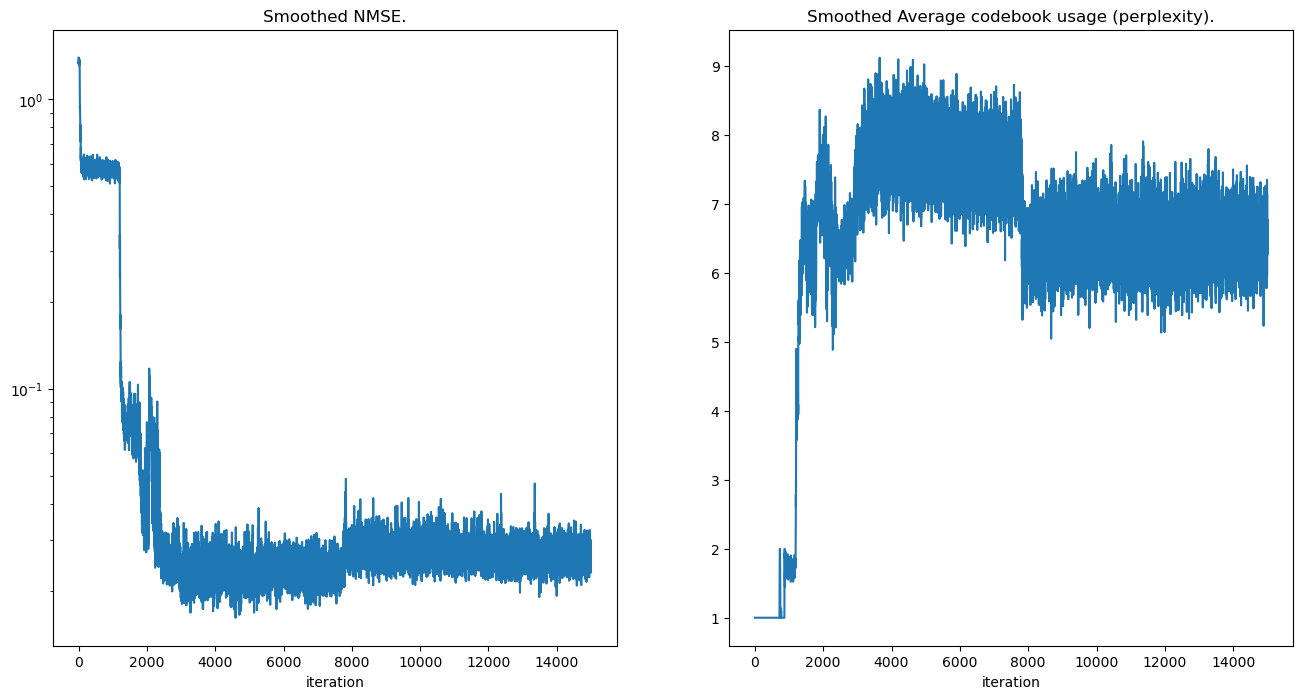

In [229]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [230]:
# gets embeddings for increasingly increasing data sizes and some permutations n stuff ;)

data = torch.tensor(dataset.sample(pad=True)['observations'])[:256,:]
data = data.to(device)
data = data.permute(0, 2 , 1)
print('Permuted Data Shape',data.shape)
z = model._encoder(data)
z = model._pre_vq_conv(z)
print('Pre-VQ Embedding Shape',z.shape)
_, quantized, _, embeddings = model._vq_vae(z)
print('Post-VQ Embedding Shape',embeddings.shape)
emb = embeddings.view(256,-1)
print('Batch-Reshaped Emb Shape',emb.shape)

emb_all = emb.cpu().detach().numpy()
emb_1 = emb[:1].cpu().detach().numpy()
emb_5 = emb[:2].cpu().detach().numpy()
emb_sub1 = emb[:128].cpu().detach().numpy()
emb_sub2 = emb[128:].cpu().detach().numpy()

print(emb_all.shape)
print(emb_1.shape)
print(emb_5.shape)
print(emb_sub1.shape)
print(emb_sub2.shape)

Permuted Data Shape torch.Size([256, 2, 512])
Pre-VQ Embedding Shape torch.Size([256, 128, 1])
Post-VQ Embedding Shape torch.Size([256, 50])
Batch-Reshaped Emb Shape torch.Size([256, 50])
(256, 50)
(1, 50)
(2, 50)
(128, 50)
(128, 50)


Text(0.5, 0, 'label')

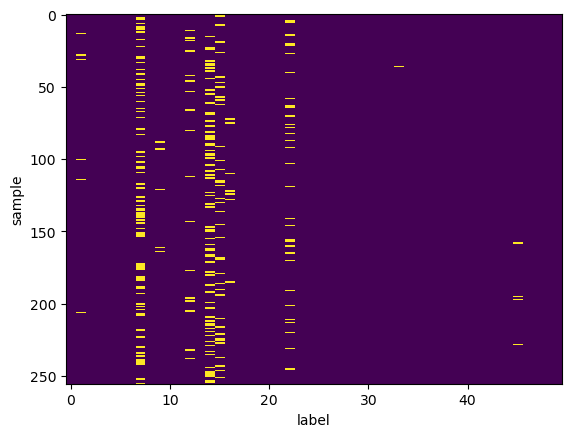

In [231]:
plt.imshow(emb_all,aspect='auto',interpolation='nearest')
plt.ylabel('sample')
plt.xlabel('label')

In [232]:
# ensuring random strajectory statistics aren't cooked

#print(train_encodings)
print('*** Default Encoding Inception')
print('Inception All :',calculate_inception_score(emb_all))
print('Inception Sub1:',calculate_inception_score(emb_sub1))
print('Inception Sub2:',calculate_inception_score(emb_sub2))
print('Inception 1:',calculate_inception_score(emb_1))
print('Inception 5:',calculate_inception_score(emb_5))



*** Default Encoding Inception
Inception All : 5.961939
Inception Sub1: 6.2279983
Inception Sub2: 5.417384
Inception 1: 1.0
Inception 5: 2.0


torch.Size([256, 50])


Text(0.5, 1.0, 'Gridland N=10 Diversity Metric Testing')

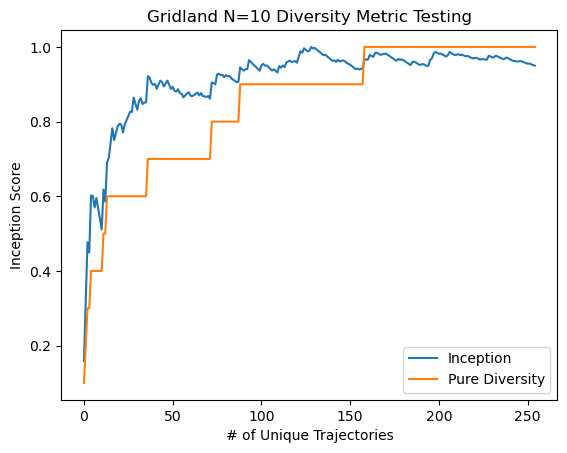

In [233]:
inception_storage = []
pure_diversity = []
print(emb.shape)
step_size = 1
max_step = 256
for i in range(1,max_step,step_size):
    emb_temp = emb[:i].cpu().detach().numpy()
    inception_storage.append(calculate_inception_score(emb_temp))
    pure_diversity.append(np.sum(np.sum(emb_temp,axis=0)/(np.sum(emb_temp,axis=0)+1e-8)))

plt.plot(np.array(range(len(inception_storage)))*step_size,inception_storage/np.max(inception_storage),label='Inception')
plt.plot(np.array(range(len(pure_diversity)))*step_size,pure_diversity/pure_diversity[-1],label='Pure Diversity')
plt.ylabel('Inception Score')
plt.xlabel('# of Unique Trajectories')
plt.legend()
plt.title('Gridland N=10 Diversity Metric Testing')

In [234]:
# (fables of the) reconstruction
data = torch.tensor(dataset.sample(pad=True)['observations'])[:256,:]
data = data.to(device)
data = data.permute(0, 2 , 1)
_, recon, _ = model(data)
data = data.cpu().detach().numpy()
recon = recon.cpu().detach().numpy()
print(data.shape)
print(recon.shape)

(256, 2, 512)
(256, 2, 512)


(256, 50)
(256,)
[14 15  7  7 22 22  7 15  7  7  7 12  7  1 22 14 12  7 12 15 22 22  7 14
 14 12 15 22  1  7  7  1 14  7 14 14 33 14  7 14 22  7 12 15 14  7 12 15
  7  7 15  7 14 12  7 14  7 15 22 15  7 14 15 22 22  7 12  7 14 14 22  7
 16 14 14 16 22 14 22  7 12 14 22  7 14 14 14 22  9 14 14 15 22  9 14  7
 14 14  7 14  1 15  7 22 14  7  7 15 14  7 16 14 12 14  1 15 15  7 15 22
  7  9 16 14 16 14  7 15 16  7 15 14  7 14  7  7 15  7  7  7  7 22  7 12
  7 15 22 14  7 14 14  7  7  7 15 14 22 22 45 14 22  9 14 14  9 22 14 14
 15 15 22 14  7  7  7  7  7 12 14 15 14  7  7  7  7 16 15 14  7  7 15 22
 14  7 15 45 12 45 12 14  7 22  7 14  7 12  1  7  7 14 15 22 14 22 14 14
 15 14  7 14 22 15 14  7 15 15 14 15 45 14  7 22 12 14  7 14  7 15 12  7
  7  7  7 15 14 22 15 14 14 14 14 15  7 14 14  7]


Text(0.5, 1.0, 'VQ-VAE Embedding Histogram')

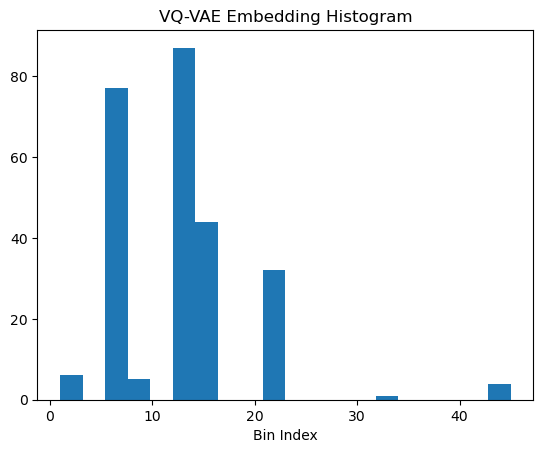

In [235]:
print(emb_all.shape)
bin_number = np.argmax(emb_all,axis=1)
print(bin_number.shape)
print(bin_number)
plt.hist(bin_number,bins=20)
plt.xlabel('Bin Index')
plt.title('VQ-VAE Embedding Histogram')

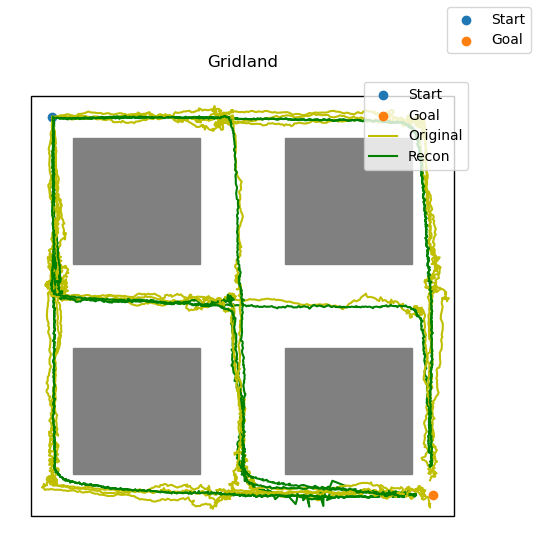

In [236]:
from gridland_environment import GridLand
env = GridLand(n_size=2,timeout = 500)
env.reset(start_idx='T0',goal_idx='B' + str(2))
fig, ax = env.get_mpl_plot()
index = 67
for index in range(10):
    if index == 0:
        ax.plot(data[index,0],data[index,1],label='Original',c='y')
        ax.plot(recon[index,0],recon[index,1],label='Recon',c='g')
    else:
        ax.plot(data[index,0],data[index,1],c='y')
        ax.plot(recon[index,0],recon[index,1],c='g')
plt.legend()

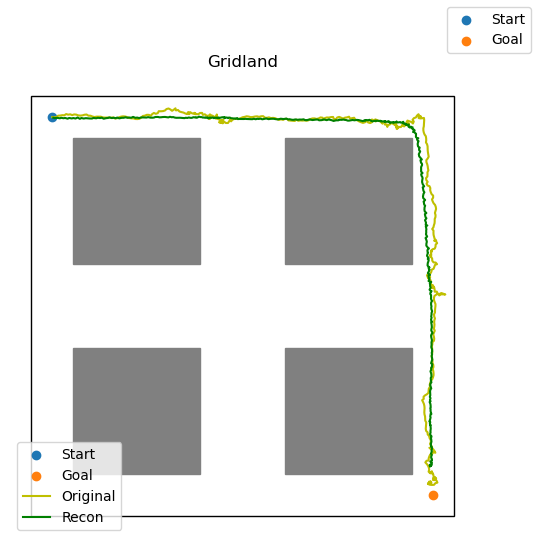

In [283]:
from gridland_environment import GridLand
env = GridLand(n_size=2,timeout = 500)
env.reset(start_idx='T0',goal_idx='B' + str(2))
fig, ax = env.get_mpl_plot()
index = np.random.randint(256)
ax.plot(data[index,0],data[index,1],label='Original',c='y')
ax.plot(recon[index,0],recon[index,1],label='Recon',c='g')
plt.legend()

### below is all the shit with a sparse VAE (doesn't work great)

In [104]:
# imports, helper functions, etc. 
# testing diversity metrics. ideally, in this case, total > train > test

# directly applying inception
# calculate inception score in numpy
from numpy import asarray
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp
import numpy as np
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=1)[:,np.newaxis]
def linear_norm(x):
    x = x / np.sum(x,axis=1)[:,np.newaxis]
    return x
# calculate the inception score for p(y|x)
def calculate_inception_score(p_yx, eps=1E-16):
	# calculate p(y)
	p_y = expand_dims(p_yx.mean(axis=0), 0)
	# kl divergence for each image
	kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
	# sum over classes
	sum_kl_d = kl_d.sum(axis=1)
	# average over images
	avg_kl_d = mean(sum_kl_d)
	# undo the logs
	is_score = exp(avg_kl_d)
	return is_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

OUTPUT_DIM = 402
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(OUTPUT_DIM, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, OUTPUT_DIM)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

# Class for autoencoder

class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-2, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, OUTPUT_DIM)
        h = self.E(x)
        self.data_rho = h.mean(0) # calculates rho from encoder activations
        out = self.D(h)
        return out
    def encode(self,x):
        x = x.view(-1, OUTPUT_DIM)
        h = self.E(x)
        return h

    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):        
        dkl = - rho * torch.log(self.data_rho) - (1-rho)*torch.log(1-self.data_rho) # calculates KL divergence
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, OUTPUT_DIM)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

# Train function

def train(model, data,rho = 0.05, epochs = 100,verbose=False):
    for epoch in range(epochs):
        model.optim.zero_grad()
        inputs = torch.tensor(data)
        output = model(inputs)
        rho_loss = model.rho_loss(rho)
        loss = model.loss(output, data) + rho_loss
        loss.backward()
        model.optim.step()
        if verbose:
            print('Epoch',epoch,'Loss',loss.item())


In [105]:
# Runs the code to generate the FlatlandPlus data!
from flatland_plus_environment import FlatLandPlus
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
MAX_EP_LENGTH = 200
TOTAL_SAMPLES = 100_000 # OGBench had 1 million but this seems more reasonable for this
HOLDOUT_SPLIT = 0.3333
RANDOM_SEED = 42
save_directory = 'flatland_data'
N_list = [2]
SIZE = 5
N = 10
# Collects and shuffles all possible Start-Goal pairs, sorts into 
# training and testing
sg_pairs = []
n_facets = N * 2 
for start_index in range(n_facets):
    for goal_index in range(n_facets):
        if start_index != goal_index:
            sg_pairs.append(tuple((start_index,goal_index)))
rng = np.random.default_rng(seed=RANDOM_SEED)
rng.shuffle(sg_pairs)
training_split = sg_pairs[:1-int(HOLDOUT_SPLIT*len(sg_pairs))]
testing_split = sg_pairs[1-int(HOLDOUT_SPLIT*len(sg_pairs)):]
assert len(sg_pairs) == len(training_split) + len(testing_split)
#print('train',training_split)
#print('test',testing_split)
# some setup stuff
timeout = MAX_EP_LENGTH
env = FlatLandPlus(n_dims = N)
n_sg_pairs = int(n_facets * (n_facets-1))
rng = np.random.default_rng(seed = 42)
gaussian_scale = 0.05
sg_index = 0
train_trajectories = []
test_trajectories = []
for sg_index in range(len(training_split)):
    # setup
    (start_index, goal_index) = training_split[sg_index]
    been_to_middle = False
    obs, info = env.reset(start_idx=start_index,goal_idx=goal_index)
    start = obs
    goal = info['goal']
    middle = np.zeros_like(start)
    truncated = False
    traj = [obs]
    # overall environment interaction loop
    while not truncated:
        if not been_to_middle: # travelling from start to middle
            # base action going towards middle
            action = middle-obs
            # adds small gaussian noise 
            action = action + rng.normal(loc=0,scale=gaussian_scale,size=action.shape)
        else: # travelling from middle to goal
            # base action going towards goal
            action = goal-obs
            # adds small gaussian noise 
            action = action + rng.normal(loc=0,scale=gaussian_scale,size=action.shape)
        # executes action
        obs, _ , _, truncated, _ = env.step(action)
        traj.append(obs)
        if np.linalg.norm(obs) < env.tolerance:
            been_to_middle = True
    # sg index handling
    train_trajectories.append(np.array(traj))
for sg_index in range(len(testing_split)):
    # setup
    (start_index, goal_index) = testing_split[sg_index]
    been_to_middle = False
    obs, info = env.reset(start_idx=start_index,goal_idx=goal_index)
    start = obs
    goal = info['goal']
    middle = np.zeros_like(start)
    truncated = False
    traj = [obs]
    # overall environment interaction loop
    while not truncated:
        if not been_to_middle: # travelling from start to middle
            # base action going towards middle
            action = middle-obs
            # adds small gaussian noise 
            action = action + rng.normal(loc=0,scale=gaussian_scale,size=action.shape)
        else: # travelling from middle to goal
            # base action going towards goal
            action = goal-obs
            # adds small gaussian noise 
            action = action + rng.normal(loc=0,scale=gaussian_scale,size=action.shape)
        # executes action
        obs, _ , _, truncated, _ = env.step(action)
        traj.append(obs)
        if np.linalg.norm(obs) < env.tolerance:
            been_to_middle = True
    # sg index handling
    test_trajectories.append(np.array(traj))

all_trajectories = np.array(test_trajectories + train_trajectories)
double_all = np.array(test_trajectories + train_trajectories+test_trajectories + train_trajectories)
train_trajectories = np.array(train_trajectories)
test_trajectories = np.array(test_trajectories)


## makes flat versions 
# train
train_traj_flat = []
for traj in train_trajectories:
    train_traj_flat.append(traj.flatten('F'))
train_traj_flat = np.array(train_traj_flat)
# test
test_traj_flat = []
for traj in test_trajectories:
    test_traj_flat.append(traj.flatten('F'))
test_traj_flat = np.array(test_traj_flat)
# all
all_traj_flat = []
for traj in all_trajectories:
    all_traj_flat.append(traj.flatten('F'))
all_traj_flat = np.array(all_traj_flat)
# double
double_all_traj_flat = []
for traj in double_all:
    double_all_traj_flat.append(traj.flatten('F'))
double_all_traj_flat = np.array(double_all_traj_flat)

In [106]:
# main trajectories
print(train_trajectories.shape)
print(test_trajectories.shape)
print(double_all.shape)
print(all_trajectories.shape)
# flattened ones
print(train_traj_flat.shape)
print(test_traj_flat.shape)
print(all_traj_flat.shape)
print(double_all_traj_flat.shape)

(255, 201, 10)
(125, 201, 10)
(760, 201, 10)
(380, 201, 10)
(255, 2010)
(125, 2010)
(380, 2010)
(760, 2010)


In [ ]:
# inception demo
p_yx = asarray([[1.0, 0.0], [1.0, 1], [0, 0], [0.0, 1.0]])
print(p_yx.shape)
score = calculate_inception_score(p_yx)

print(score)

(4, 2)
1.9999999999999996


In [125]:
# playing around more with inception
print(calculate_inception_score(asarray([[1.0, 0.0],[0.0, 1.0]])))
print(calculate_inception_score(asarray([[1.0, 0.0], [1.0, 1], [0, 0], [0.0, 1.0]])))
print(calculate_inception_score(asarray([[1.0, 0.0], [1.0, 1], [0, 0], [0.0, 1.0],[0.5,0.5]])))

1.9999999999999996
1.9999999999999996
1.741101126592248


In [108]:
# just trying to run it w/o anything else does not work pepo sadge
print('Inception Train:',calculate_inception_score(all_traj_flat))
# what about flattening the obs.dimension?
train_traj_flat = []
for traj in train_trajectories:
    train_traj_flat.append(traj.flatten('F'))
train_traj_flat = np.array(train_traj_flat)

print(train_traj_flat.shape)
print('Inception Train:',calculate_inception_score(train_traj_flat))

Inception Train: nan
(255, 2010)
Inception Train: nan


/tmp/ipykernel_772214/14425345.py:23: RuntimeWarning: invalid value encountered in log
  kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))


In [140]:
# trains very simple sparse vae on original data
hidden_layers = 200
network = Net(hidden_layers)
train(model = network, data = torch.tensor(all_traj_flat,dtype=torch.float),epochs=1000,verbose=False,rho=1e-7)

/tmp/ipykernel_772214/14425345.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data)


In [110]:
if N == 2:
    original_path = test_traj_flat[0]
    reconstructed_path = network(torch.tensor(original_path,dtype=torch.float)).detach().numpy()[0]
    #plt.scatter(original_path[:int(OUTPUT_DIM/2)],original_path[int(OUTPUT_DIM/2):],c=range(len(original_path[int(OUTPUT_DIM/2):])),s=5,label='Original')
    #plt.scatter(reconstructed_path[:int(OUTPUT_DIM/2)],reconstructed_path[int(OUTPUT_DIM/2):],c=range(len(reconstructed_path[int(OUTPUT_DIM/2):])),s=5,label='Reconstructed')
    plt.scatter(original_path[:int(OUTPUT_DIM/2)],original_path[int(OUTPUT_DIM/2):],s=5,label='Original')
    plt.scatter(reconstructed_path[:int(OUTPUT_DIM/2)],reconstructed_path[int(OUTPUT_DIM/2):],s=5,label='Reconstructed')
    plt.xlim(-0.5,0.5)
    plt.ylim(-0.5,0.5)
    plt.legend()
    plt.colorbar()
    #print(original_path[:int(OUTPUT_DIM/2)])

In [141]:
# looking at encodings or w/e
train_encodings = network.encode(torch.tensor(train_traj_flat,dtype=torch.float)).detach().numpy()
test_encodings = network.encode(torch.tensor(test_traj_flat,dtype=torch.float)).detach().numpy()
all_encodings = network.encode(torch.tensor(all_traj_flat,dtype=torch.float)).detach().numpy()
double_encodings = network.encode(torch.tensor(double_all_traj_flat,dtype=torch.float)).detach().numpy()
random_traj = np.random.normal(scale=np.sqrt(np.var(all_traj_flat)),loc=np.mean(all_traj_flat),size=torch.tensor(double_all_traj_flat,dtype=torch.float).shape)
random_encodings = network.encode(torch.tensor(random_traj,dtype=torch.float)).detach().numpy()
## trying forms of encoding level normalization
# normal linear normalization
""" train_encodings = train_encodings / np.sum(train_encodings,axis=1)[:,np.newaxis]
test_encodings = test_encodings / np.sum(test_encodings,axis=1)[:,np.newaxis]
all_encodings = all_encodings / np.sum(all_encodings,axis=1)[:,np.newaxis]
double_encodings = double_encodings / np.sum(double_encodings,axis=1)[:,np.newaxis]
random_encodings = random_encodings / np.sum(random_encodings,axis=1)[:,np.newaxis] """

# ensuring random strajectory statistics aren't cooked
print('All trajectory statistics')
print(np.mean(all_traj_flat))
print(np.sqrt(np.var(all_traj_flat)))
print('Random trajectory statistics')
print(np.mean(random_traj))
print(np.sqrt(np.var(random_traj)))

#print(train_encodings)
print('*** Default Encoding Inception')
print('Inception Train:',calculate_inception_score(train_encodings))
print('Inception Test:',calculate_inception_score(test_encodings))
print('Inception All:',calculate_inception_score(all_encodings))
print('Inception Double:',calculate_inception_score(double_encodings))
print('Inception Random:',calculate_inception_score(random_encodings))

print('*** Softmax Inception')
print('Inception Train:',calculate_inception_score(softmax(train_encodings)))
print('Inception Test:',calculate_inception_score(softmax(test_encodings)))
print('Inception All:',calculate_inception_score(softmax(all_encodings)))
print('Inception Double:',calculate_inception_score(softmax(double_encodings)))
print('Inception Random:',calculate_inception_score(softmax(random_encodings)))

print('*** Linear Norm Inception')
print('Inception Train:',calculate_inception_score(linear_norm(train_encodings)))
print('Inception Test:',calculate_inception_score(linear_norm(test_encodings)))
print('Inception All:',calculate_inception_score(linear_norm(all_encodings)))
print('Inception Double:',calculate_inception_score(linear_norm(double_encodings)))
print('Inception Random:',calculate_inception_score(linear_norm(random_encodings)))

All trajectory statistics
3.878565328070077e-05
0.05043287442554098
Random trajectory statistics
6.774086974583675e-05
0.050418834147812175
*** Default Encoding Inception
Inception Train: 1.2393476
Inception Test: 1.248686
Inception All: 1.2424339
Inception Double: 1.2424349
Inception Random: 6159.112
*** Softmax Inception
Inception Train: 1.0000696
Inception Test: 1.000075
Inception All: 1.0000713
Inception Double: 1.0000713
Inception Random: 1.0000687
*** Linear Norm Inception
Inception Train: 1.0322046
Inception Test: 1.0338861
Inception All: 1.032762
Inception Double: 1.032762
Inception Random: 1.0123907


In [112]:
print(np.sum(train_encodings, axis=1))

[2.476017  2.6168957 2.0614593 ... 2.895568  3.6075907 2.4735463]


(1275, 200)


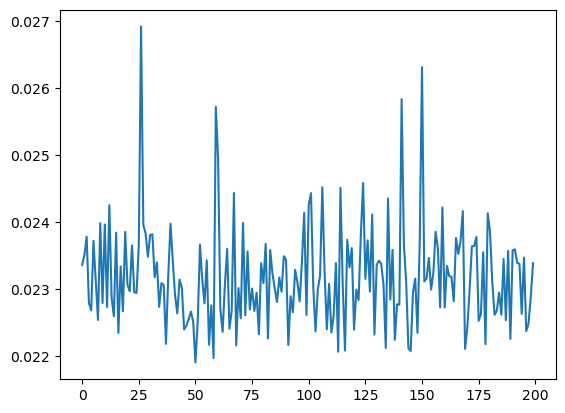

In [146]:
print(train_encodings.shape)
plt.plot(train_encodings[50])

In [143]:
print(np.mean(train_encodings))
print(np.max(train_encodings))

0.021819869
0.4998144
